# Import Python packages

In [1]:
from numpy.random import seed
seed(1)
import tensorflow as tf
print(tf.__version__)
from tensorflow.random import set_seed as tf_set_seed
tf_set_seed(2)
tf.config.list_physical_devices(
    device_type=None
)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import pickle
import pandas as pd
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True)
import matplotlib.pyplot as plt
import warnings

# Define Keras model
from tensorflow.keras.layers import (
    Input, Embedding, Dense, BatchNormalization)

from nfp.layers import GRUStep, Embedding2D, Squeeze, MessageLayer, Set2Set
from nfp.models import GraphModel
from nfp.preprocessing import GraphSequence, AdsGraphPreprocessor

2.5.0


# Load data

In [2]:
data = pd.read_csv('Oads_Mo2C_catalysts_graphml.csv')
graphStructure = pd.read_csv('graph_structure_2ndNN_ini.csv.gz',
                             compression='gzip')
dataIni = pd.merge(data,graphStructure,on='graphFileName')
dataIni['nodes']=dataIni['nodes'].apply(eval)
dataIni['edges']=dataIni['edges'].apply(eval)
dataIni['atomFeatures']=dataIni['atomFeatures'].apply(eval)
dataIni['bondFeatures']=dataIni['bondFeatures'].apply(eval)
dataIni['connectivity']=dataIni['connectivity'].apply(eval)
print(dataIni.shape)

(20177, 10)


# Split train/validation/test 

In [3]:
test = dataIni.sample(frac=0.2, random_state=0)
train_valid = dataIni[~dataIni.index.isin(test.index)]
train = train_valid.sample(frac=0.75, random_state=0)
valid = train_valid[~train_valid.index.isin(train.index)]

y_train = train['bindingEnergy(eV)'].values.reshape(-1, 1)
y_test = test['bindingEnergy(eV)'].values.reshape(-1, 1)
y_valid = valid['bindingEnergy(eV)'].values.reshape(-1, 1)

# Encode atom, bond, and connectivity feature matrices

In [4]:
preprocessor = AdsGraphPreprocessor()
inputs_train = preprocessor.fit_df(train)
inputs_test = preprocessor.predict_df(test)
inputs_valid = preprocessor.predict_df(valid)

# Create generatators 

In [5]:
batch_size = 70
train_generator = GraphSequence(inputs_train, y_train, batch_size)
test_generator = GraphSequence(inputs_test, y_test, batch_size)
valid_generator = GraphSequence(inputs_valid, y_valid, batch_size)

# Specify model parameters

In [6]:
# Raw (integer) graph inputs
node_graph_indices = Input(shape=(1,), name='node_graph_indices', dtype='int32') 
atom_types = Input(shape=(1,), name='atom', dtype='int32')
bond_types = Input(shape=(1,), name='bond', dtype='int32')
connectivity = Input(shape=(2,), name='connectivity', dtype='int32')

squeeze = Squeeze()

snode_graph_indices = squeeze(node_graph_indices)
satom_types = squeeze(atom_types)
sbond_types = squeeze(bond_types)
# Initialize RNN and MessageLayer instances
atom_features = 32

print(preprocessor.atom_classes)
print(preprocessor.bond_classes)

1845
1806


In [7]:
# Initialize the atom states
atom_state = Embedding(
    preprocessor.atom_classes,
    atom_features, name='atom_embedding')(satom_types)
# Initialize the bond states
bond_matrix = Embedding2D(
    preprocessor.bond_classes,
    atom_features, name='bond_embedding')(sbond_types)

atom_rnn_layer = GRUStep(atom_features)
message_layer = MessageLayer(reducer='sum', dropout=0.1) # 0.1

In [8]:
message_steps = 9
# Perform the message passing
for _ in range(message_steps):

    # Get the message updates to each atom
    message = message_layer([atom_state, bond_matrix, connectivity])

    # Update memory and atom states
    atom_state = atom_rnn_layer([message, atom_state])

# Read-out layer 
set2set_steps=3
mol_fingerprint = Set2Set(set2set_steps,name='graph_fingerprint')([atom_state, snode_graph_indices])

# Dense layers
mol_fingerprint1 = Dense(256, activation='relu', name='mfp1')(mol_fingerprint) #128, sigmoid
mol_state1 = BatchNormalization(momentum=0.9)(mol_fingerprint1)

mol_fingerprint2 = Dense(32, activation='relu', name='mfp2')(mol_state1)  #64, sigmoid
mol_state2 = BatchNormalization(momentum=0.9)(mol_fingerprint2)

mol_fingerprint3 = Dense(256, activation='relu', name='mfp3')(mol_state2)  #64, sigmoid
mol_state3 = BatchNormalization(momentum=0.9)(mol_fingerprint3)

out = Dense(1, name='output')(mol_state3)
model = GraphModel([node_graph_indices, atom_types, bond_types, connectivity], [out])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0010158), loss='mse',metrics=['mae'])  #lr=1E-3
model.summary()
#plot_model(model,show_shapes=True)

W0309 09:41:09.168399 4683628032 deprecation.py:534] From /Users/hadoan/anaconda3/envs/mlmat/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py:5049: calling gather (from tensorflow.python.ops.array_ops) with validate_indices is deprecated and will be removed in a future version.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Model: "graph_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
bond (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
squeeze (Squeeze)               (None,)              0           node_graph_indices[0][0]         
                                                                 atom[0][0]                       
                                                                 bond[0][0]                       
________________________________________________________________________________________

/Users/hadoan/anaconda3/envs/mlmat/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Train the model

In [9]:
name = 'Oads_Mo2C_2ndNN_molfp' 
metric = 'val_mae'
callbacks = ModelCheckpoint(filepath=r"checkpoints/{}".format(name), monitor=metric,
                        verbose=2, save_best_only=True, mode='min')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    hist = model.fit_generator(train_generator, 
                                validation_data=valid_generator, 
                                epochs=20,    # Set to 200 for production run
                                verbose=2,
                                callbacks=[callbacks])

best_model_path = 'checkpoints/{}'.format(name)
model = load_model(best_model_path)
model.save('checkpoints/{}/{}.h5'.format(name,name))
dbfile = open('checkpoints/{}/converter.pkl'.format(name), 'ab')
pickle.dump(preprocessor, dbfile)                     
dbfile.close()

Epoch 1/20
173/173 - 37s - loss: 4.2766 - mae: 1.6138 - val_loss: 0.4314 - val_mae: 0.5096

Epoch 00001: val_mae improved from inf to 0.50956, saving model to checkpoints/Oads_Mo2C_2ndNN_molfp
Epoch 2/20
173/173 - 34s - loss: 0.3401 - mae: 0.4459 - val_loss: 0.2778 - val_mae: 0.3971

Epoch 00002: val_mae improved from 0.50956 to 0.39705, saving model to checkpoints/Oads_Mo2C_2ndNN_molfp
Epoch 3/20
173/173 - 34s - loss: 0.2440 - mae: 0.3755 - val_loss: 0.2252 - val_mae: 0.3477

Epoch 00003: val_mae improved from 0.39705 to 0.34767, saving model to checkpoints/Oads_Mo2C_2ndNN_molfp
Epoch 4/20
173/173 - 34s - loss: 0.1861 - mae: 0.3269 - val_loss: 0.2851 - val_mae: 0.4042

Epoch 00004: val_mae did not improve from 0.34767
Epoch 5/20
173/173 - 34s - loss: 0.1620 - mae: 0.3077 - val_loss: 0.1916 - val_mae: 0.3171

Epoch 00005: val_mae improved from 0.34767 to 0.31710, saving model to checkpoints/Oads_Mo2C_2ndNN_molfp
Epoch 6/20
173/173 - 34s - loss: 0.1352 - mae: 0.2809 - val_loss: 0.2124 -

# Plot results

/Users/hadoan/anaconda3/envs/mlmat/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/Users/hadoan/anaconda3/envs/mlmat/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_graph_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


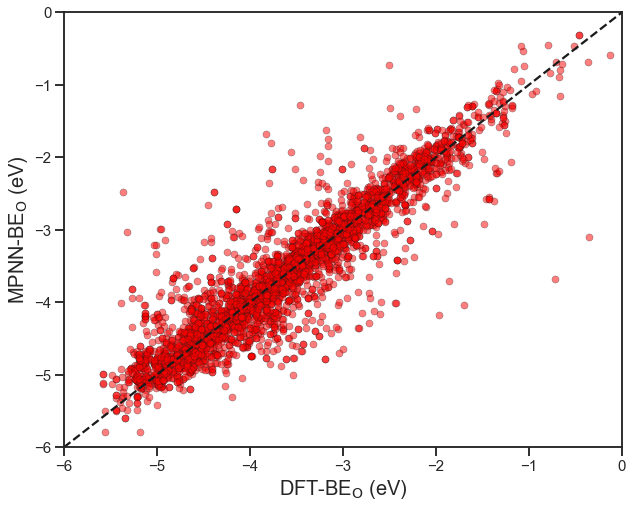

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
axisLabelSize = 20
tickLabelSize = 15
markerSize = 50
y_train_pred = model.predict_generator(GraphSequence(inputs_train, batch_size=70, shuffle=False))
y_test_pred = model.predict_generator(GraphSequence(inputs_test, batch_size=70, shuffle=False))
y_valid_pred = model.predict_generator(GraphSequence(inputs_valid, batch_size=70, shuffle=False))

dfTrainResult = pd.DataFrame(train.graphFileName,columns=['graphFileName'])
dfTestResult = pd.DataFrame(test.graphFileName,columns=['graphFileName'])
dfValidResult = pd.DataFrame(valid.graphFileName,columns=['graphFileName'])

dfTrainResult['y_train'] = y_train
dfTrainResult['y_train_pred'] = y_train_pred
dfTestResult['y_test'] = y_test
dfTestResult['y_test_pred'] = y_test_pred
dfValidResult['y_valid'] = y_valid
dfValidResult['y_valid_pred'] = y_valid_pred
dfTrainResult.to_csv('checkpoints/{}/{}_trainResults.csv'.format(name,name),index=None)
dfTestResult.to_csv('checkpoints/{}/{}_testResults.csv'.format(name,name),index=None)
dfValidResult.to_csv('checkpoints/{}/{}_validResults.csv'.format(name,name),index=None)

for label in ax.xaxis.get_ticklabels(): 
    label.set_fontsize(tickLabelSize)
for label in ax.yaxis.get_ticklabels(): 
    label.set_fontsize(tickLabelSize)

plt.scatter(y_test, y_test_pred, s=markerSize, color='red', linewidth=0.5, edgecolor='k',alpha=0.5)
plt.plot([-6,0],[-6,0],'k--')
plt.xlim(-6.,0.)
plt.ylim(-6.,0.)
plt.xlabel(r'DFT-BE$\rm_O$ (eV)',fontsize=axisLabelSize)
plt.ylabel(r'MPNN-BE$\rm_O$ (eV)',fontsize=axisLabelSize)
plt.savefig('checkpoints/{}/test_parity.png'.format(name))